In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', version=1)
# mnist.keys()

In [3]:
# X, y = mnist['data'], mnist['target']

In [4]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

### Getting Started with Pytorch

In [5]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)


In [6]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((X_train, y_train), (X_test, y_test), _) = pickle.load(f, encoding="latin-1")

In [7]:
import torch

X_train = (X_train/255. - 0.5) / 0.5
X_test = (X_test/255. - 0.5) / 0.5

# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)

X_train, y_train, X_test, y_test = map(
    torch.tensor, (X_train, y_train, X_test, y_test)
)

# X_train = X_train.type(torch.long)
# X_test = X_test.type(torch.long)
# y_train = y_train.type(torch.long)
# y_test = y_test.type(torch.long)


bs = 64

In [8]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

In [9]:
from torch.utils.data import DataLoader

def get_data(train_ds, test_ds, bs=64):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(test_ds, batch_size=bs * 2),
    )

In [10]:
train_dl, test_dl = get_data(train_ds, test_ds)

In [11]:
import torch.nn.functional as F
from torch import nn

loss_func = F.cross_entropy
# loss_func = nn.CrossEntropyLoss()

In [12]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [13]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [14]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl = WrappedDataLoader(train_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

In [83]:
from IPython.core.debugger import set_trace

import numpy as np


def fit(epochs, model, loss_func, opt, train_dl, valid_dl, c=3, p=32):
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_test_loss = []
    epoch_test_acc = []
    

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_nums = []
        train_accs = []
        for xb, yb in train_dl:
            losses, nums = loss_batch(model, loss_func, xb, yb, opt)
            train_accs.append(accuracy(model(xb), yb))
            train_losses.append(losses)
            train_nums.append(nums)
        train_loss = np.sum(np.multiply(np.array(train_losses), np.array(train_nums))) / np.sum(train_nums)
        epoch_train_loss.append(train_loss)
        train_acc = np.sum(np.multiply(np.array(train_accs), np.array(train_nums))) / np.sum(train_nums)
        epoch_train_acc.append(train_acc)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
            )
            accuracies = [accuracy(model(xb), yb) for xb, yb in test_dl]
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        epoch_test_loss.append(val_loss)
        val_acc = np.sum(np.multiply(accuracies, nums)) / np.sum(nums)
        epoch_test_acc.append(val_acc)
        
        print('epoch #: {}, train_loss: {}, val_loss: {}'.format(epoch, train_loss, val_loss))
        print('train_accuracy: {}, val_accuracy: {}'.format(train_acc, val_acc))
        print('=======================================')

    return epoch_train_loss, epoch_test_loss


In [16]:


class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [17]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    # Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Flatten(),
)

from torch import optim

lr = 0.5  # learning rate
epochs = 15
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, test_dl, c=1, p=28)

epoch #: 0, train_loss: 1.2238200718688965, val_loss: 0.8477772963047028


KeyboardInterrupt: ignored

### CNNs for CIFAR-10

In [18]:
from sklearn.datasets import fetch_openml
cifar_10_small = fetch_openml('CIFAR_10_Small', version=1)
cifar_10_small.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [92]:
X, y = cifar_10_small['data'], cifar_10_small['target']

In [98]:
X.shape

(20000, 3072)

In [111]:
from sklearn.model_selection import train_test_split
X_train_cifar, X_test_cifar, y_train_cifar, y_test_cifar = train_test_split(X, y, test_size=0.25, random_state=42)

In [112]:
# import torchvision
# import torchvision.transforms as transforms

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [113]:

X_train_cifar /= 255.
X_test_cifar /= 255.
X_train_cifar

array([[0.3372549 , 0.32156863, 0.28627451, ..., 0.56470588, 0.56862745,
        0.59215686],
       [0.00784314, 0.00784314, 0.01176471, ..., 0.30980392, 0.31372549,
        0.31764706],
       [0.69803922, 0.69019608, 0.69411765, ..., 0.83137255, 0.8       ,
        0.78039216],
       ...,
       [0.6       , 0.61960784, 0.65882353, ..., 0.82745098, 0.82352941,
        0.8       ],
       [1.        , 1.        , 1.        , ..., 0.21960784, 0.23137255,
        0.23921569],
       [0.37254902, 0.37647059, 0.36862745, ..., 0.37254902, 0.36862745,
        0.36470588]])

In [114]:
import torch

X_train_cifar = (X_train_cifar - 0.5) / 0.5
X_test_cifar = (X_test_cifar - 0.5) / 0.5

y_train_cifar = y_train_cifar.astype(np.float32)
y_test_cifar = y_test_cifar.astype(np.float32)

X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar = map(
    torch.tensor, (X_train_cifar, y_train_cifar, X_test_cifar, y_test_cifar)
)


X_train_cifar = X_train_cifar.type(torch.float32)
X_test_cifar = X_test_cifar.type(torch.float32)
y_train_cifar = y_train_cifar.type(torch.float32)
y_test_cifar = y_test_cifar.type(torch.float32)

bs = 64

In [115]:
X_train_cifar

tensor([[-0.3255, -0.3569, -0.4275,  ...,  0.1294,  0.1373,  0.1843],
        [-0.9843, -0.9843, -0.9765,  ..., -0.3804, -0.3725, -0.3647],
        [ 0.3961,  0.3804,  0.3882,  ...,  0.6627,  0.6000,  0.5608],
        ...,
        [ 0.2000,  0.2392,  0.3176,  ...,  0.6549,  0.6471,  0.6000],
        [ 1.0000,  1.0000,  1.0000,  ..., -0.5608, -0.5373, -0.5216],
        [-0.2549, -0.2471, -0.2627,  ..., -0.2549, -0.2627, -0.2706]])

In [116]:
train_ds = TensorDataset(X_train_cifar, y_train_cifar)
test_ds = TensorDataset(X_test_cifar, y_test_cifar)

train_dl, test_dl = get_data(train_ds, test_ds)

In [117]:
def preprocess_cifar(x, y):
    return x.view(-1, 3, 32, 32), y


train_dl = WrappedDataLoader(train_dl, preprocess_cifar)
test_dl = WrappedDataLoader(test_dl, preprocess_cifar)

In [118]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb.type(torch.long))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [120]:
# model = nn.Sequential(
#     nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1),
#     nn.ReLU(),
#     nn.AdaptiveAvgPool2d(1),
#     # Lambda(lambda x: x.view(x.size(0), -1)),
#     nn.Flatten(),
# )

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.avgpool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        return x

model = Net()



from torch import optim

momentum = 0.9
lr = 0.5  # learning rate
epochs = 20
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_losses, test_losses = fit(epochs, model, loss_func, opt, train_dl, test_dl)

epoch #: 0, train_loss: 2.2543267957051594, val_loss: 2.202810736846924
train_accuracy: 0.1826, val_accuracy: 0.2062
epoch #: 1, train_loss: 2.173349174626668, val_loss: 2.0802667461395266
train_accuracy: 0.22579999998410544, val_accuracy: 0.273
epoch #: 2, train_loss: 2.079800208282471, val_loss: 2.065936675643921
train_accuracy: 0.2811333333174388, val_accuracy: 0.279
epoch #: 3, train_loss: 2.042386731783549, val_loss: 2.008116427230835
train_accuracy: 0.2948666666507721, val_accuracy: 0.309
epoch #: 4, train_loss: 2.027085730934143, val_loss: 2.02074681968689
train_accuracy: 0.31, val_accuracy: 0.3014
epoch #: 5, train_loss: 2.011575531133016, val_loss: 2.075202090072632
train_accuracy: 0.3150666666507721, val_accuracy: 0.2586
epoch #: 6, train_loss: 2.0022964749654135, val_loss: 1.9857430316925049
train_accuracy: 0.3191333333492279, val_accuracy: 0.3164
epoch #: 7, train_loss: 1.9911084438323974, val_loss: 2.0215638916015624
train_accuracy: 0.32633333331743875, val_accuracy: 0.292

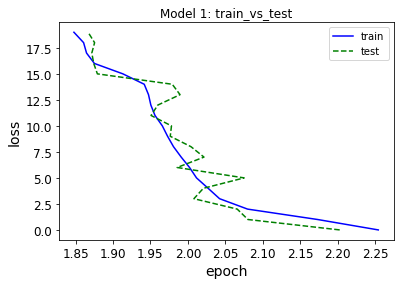

In [121]:
plt.plot(train_losses, range(len(train_losses)), 'b-', label='train' )
plt.plot(test_losses, range(len(test_losses)), 'g--', label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model 1: train_vs_test')
plt.legend()
plt.show()

In [137]:
model2 = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Flatten(),
    nn.Linear(10*16*16, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.Softmax(),
)

from torch import optim

momentum = 0.9
lr = 0.5  # learning rate
epochs = 20
opt = optim.SGD(model2.parameters(), lr=lr, momentum=momentum)

train_losses, test_losses = fit(epochs, model2, loss_func, opt, train_dl, test_dl)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch #: 0, train_loss: 2.348312445449829, val_loss: 2.359950883483887
train_accuracy: 0.11173333332538604, val_accuracy: 0.1012
epoch #: 1, train_loss: 2.3598842149098713, val_loss: 2.359950883483887
train_accuracy: 0.10126666666666667, val_accuracy: 0.1012


KeyboardInterrupt: ignored

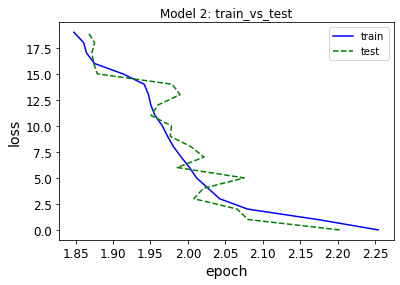

In [129]:
plt.plot(train_losses, range(len(train_losses)), 'b-', label='train' )
plt.plot(test_losses, range(len(test_losses)), 'g--', label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model 2: train_vs_test')
plt.legend()
plt.show()

In [130]:

for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()


momentum = 0.9
lr = 0.05  # learning rate
epochs = 10
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_losses, test_losses = fit(epochs, model, loss_func, opt, train_dl, test_dl)

epoch #: 0, train_loss: 2.1813290364583335, val_loss: 2.10813876953125
train_accuracy: 0.2147999999920527, val_accuracy: 0.2438
epoch #: 1, train_loss: 2.0103321541468304, val_loss: 1.9459406703948974
train_accuracy: 0.2986666666507721, val_accuracy: 0.2978
epoch #: 2, train_loss: 1.8378089210510253, val_loss: 1.7591144012451172
train_accuracy: 0.342, val_accuracy: 0.3522
epoch #: 3, train_loss: 1.7249128558476765, val_loss: 1.677977531814575
train_accuracy: 0.3646, val_accuracy: 0.3856
epoch #: 4, train_loss: 1.6858721939086914, val_loss: 1.6395804386138917
train_accuracy: 0.3923999999920527, val_accuracy: 0.411
epoch #: 5, train_loss: 1.642309425163269, val_loss: 1.6485026245117187
train_accuracy: 0.4048, val_accuracy: 0.3914
epoch #: 6, train_loss: 1.6083005155563355, val_loss: 1.5752708694458009
train_accuracy: 0.42086666668256123, val_accuracy: 0.4236
epoch #: 7, train_loss: 1.5665836796442667, val_loss: 1.5614890605926515
train_accuracy: 0.4424000000158946, val_accuracy: 0.44
epo

This learning rate is working much better than the previous one!

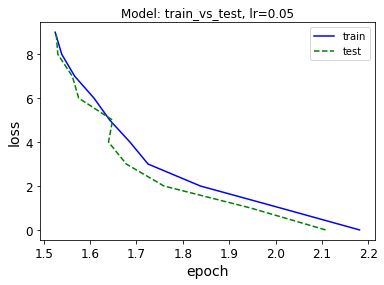

In [131]:
plt.plot(train_losses, range(len(train_losses)), 'b-', label='train' )
plt.plot(test_losses, range(len(test_losses)), 'g--', label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model: train_vs_test, lr=0.05')
plt.legend()
plt.show()

In [132]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

momentum = 0.9
lr = 0.001  # learning rate
epochs = 20
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_losses, test_losses = fit(epochs, model, loss_func, opt, train_dl, test_dl)

epoch #: 0, train_loss: 2.2984830097198485, val_loss: 2.290761209869385
train_accuracy: 0.1092, val_accuracy: 0.1568
epoch #: 1, train_loss: 2.286902719624837, val_loss: 2.283383158493042
train_accuracy: 0.15413333334128063, val_accuracy: 0.171
epoch #: 2, train_loss: 2.279693489964803, val_loss: 2.276878846740723
train_accuracy: 0.17926666666666666, val_accuracy: 0.1924
epoch #: 3, train_loss: 2.272614423497518, val_loss: 2.270512446975708
train_accuracy: 0.18799999998410544, val_accuracy: 0.202
epoch #: 4, train_loss: 2.2635555866241455, val_loss: 2.260810694885254
train_accuracy: 0.19660000000397365, val_accuracy: 0.2028
epoch #: 5, train_loss: 2.2529517042795817, val_loss: 2.2527031330108644
train_accuracy: 0.20226666666666668, val_accuracy: 0.2152
epoch #: 6, train_loss: 2.2433364435831704, val_loss: 2.2454196990966797
train_accuracy: 0.20953333333333332, val_accuracy: 0.214
epoch #: 7, train_loss: 2.2342739218393963, val_loss: 2.2382836177825927
train_accuracy: 0.2165333333174387

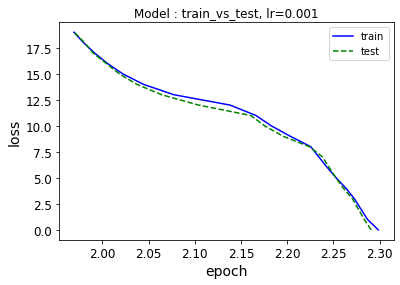

In [133]:
plt.plot(train_losses, range(len(train_losses)), 'b-', label='train' )
plt.plot(test_losses, range(len(test_losses)), 'g--', label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model : train_vs_test, lr=0.001')
plt.legend()
plt.show()

In [134]:
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

momentum = 0.5
lr = 0.05  # learning rate
epochs = 20
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_losses, test_losses = fit(epochs, model, loss_func, opt, train_dl, test_dl)

epoch #: 0, train_loss: 2.249336456680298, val_loss: 2.2035163074493407
train_accuracy: 0.20213333331743877, val_accuracy: 0.2274
epoch #: 1, train_loss: 2.1357764709472655, val_loss: 2.0911544044494628
train_accuracy: 0.2521333333333333, val_accuracy: 0.265
epoch #: 2, train_loss: 2.0613379079818728, val_loss: 1.9770293077468872
train_accuracy: 0.2847333333174388, val_accuracy: 0.2698
epoch #: 3, train_loss: 1.9068579023361205, val_loss: 1.8775856044769288
train_accuracy: 0.3233999999841054, val_accuracy: 0.3184
epoch #: 4, train_loss: 1.8335252893447875, val_loss: 1.8237731464385987
train_accuracy: 0.34253333333333336, val_accuracy: 0.3318
epoch #: 5, train_loss: 1.783762150891622, val_loss: 1.7843626745224
train_accuracy: 0.3646, val_accuracy: 0.33
epoch #: 6, train_loss: 1.7526223329544068, val_loss: 1.7450536378860473
train_accuracy: 0.3712, val_accuracy: 0.3544
epoch #: 7, train_loss: 1.7294627758661907, val_loss: 1.7381271408081054
train_accuracy: 0.3825333333492279, val_accurac

In [ ]:
plt.plot(train_losses, range(len(train_losses)), 'b-', label='train' )
plt.plot(test_losses, range(len(test_losses)), 'g--', label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model : train_vs_test, lr=0.001')
plt.legend()
plt.show()